In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import time
import datetime
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import tqdm

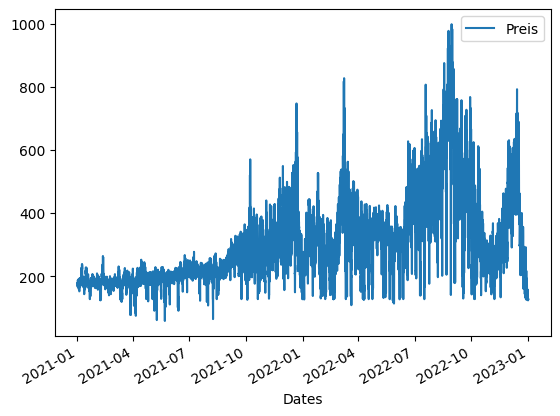

,Preis
count,17520.000000
mean,294.148030
std,133.091961
min,59.000000
25%,195.265000
50%,250.645000
75%,353.542500
max,999.000000


In [2]:


def get_price(path):
    
    df = pd.read_csv(path, skiprows=1)
    
    df = df.rename(columns={'Unnamed: 0':'Dates'})
    df.Dates = df.Dates.apply(lambda x: x[:13])
    df.Dates = pd.to_datetime(df.Dates, format = '%Y-%m-%dT%H')
    df.index = pd.DatetimeIndex(df.Dates)
    df = df.drop(columns=["Dates"])
    preis = df.iloc[:,-1]
    return preis


price = pd.concat([
    get_price("energy-charts_Stromproduktion_und_Börsenstrompreise_in_Deutschland_2021.csv"),
    get_price("energy-charts_Stromproduktion_und_Börsenstrompreise_in_Deutschland_2022.csv"),
])

price += 128

price.name = "Preis"
price = price.to_frame()
price.plot()
plt.show()
price.describe()

In [3]:
df = pd.read_csv("processed_data.csv", index_col=0, parse_dates=True)
df = df[["Consumption"]].join(price)
df = df.dropna()
df.Preis /= 10
df["Kosten"] = (df.Consumption / 1000 * df.Preis)
df.Kosten.sum()

88142.454475

In [4]:
import pandas as pd
import datetime


def calc_reduction(date):

    lower_index = datetime.datetime(date.year, date.month, date.day, MENSCHLISCHE_STUNDEN[0])
    upper_index = datetime.datetime(date.year, date.month, date.day, MENSCHLISCHE_STUNDEN[1])


    day = df.loc[lower_index:upper_index].copy()


    total_cost = day.Kosten.sum()
    lowest = day.Kosten.sum()


    for inner_loop in range(MENSCHLISCHE_STUNDEN[0], MENSCHLISCHE_STUNDEN[1] - MENGE_AN_STUNDEN + 1):
        
        for outer_loop in range(MENSCHLISCHE_STUNDEN[0], MENSCHLISCHE_STUNDEN[1] - MENGE_AN_STUNDEN + 1):
            
            if inner_loop == outer_loop:
                continue
            
                    
            vals = day.Consumption.values.copy()
            vals[inner_loop: inner_loop + MENGE_AN_STUNDEN] -= EINSPARUNG_PRO_STUNDE
            vals[outer_loop: outer_loop + MENGE_AN_STUNDEN] += EINSPARUNG_PRO_STUNDE
            new_cost = np.dot(vals, day.Preis.values) / 1000
            
            
            lowest = min(new_cost, lowest)
            
    return total_cost, lowest

In [5]:
df

,Consumption,Preis,Kosten
Dates,,,
2021-06-01 00:00:00,222.0,18.998,4.217556
2021-06-01 01:00:00,142.0,18.694,2.654548
2021-06-01 02:00:00,148.0,18.450,2.730600
2021-06-01 03:00:00,159.0,18.423,2.929257
2021-06-01 04:00:00,123.0,18.495,2.274885
...,...,...,...
2022-05-31 19:00:00,379.0,38.302,14.516458
2022-05-31 20:00:00,227.0,38.667,8.777409
2022-05-31 21:00:00,236.0,37.551,8.862036


In [6]:
MENSCHLISCHE_STUNDEN = 8, 20
EINSPARUNG_PRO_STUNDE = 1000
MENGE_AN_STUNDEN = 2

In [7]:
alldates = np.unique(df.index.date)

vals = [calc_reduction(date) for date in tqdm.tqdm(alldates)]


res = pd.DataFrame(vals, columns= ["Before", "After"])

  4%|▍         | 16/365 [00:00<00:02, 159.44it/s]

100%|██████████| 365/365 [00:01<00:00, 235.68it/s]


In [8]:
res["Saved"] = res.Before - res.After
res["Relative"] = res.Saved / res.Before
res.mean()

Before      163.532527
After        97.410888
Saved        66.121638
Relative      0.433503
dtype: float64

In [9]:
total_reward = res.Saved.sum()
total_reward

24134.398

In [10]:
total_reward/100

241.34398000000002

In [11]:
total_reward/df.Kosten.sum()

0.27381127679902856